In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import pickle

Dataset was obtained from kaggle from: https://www.kaggle.com/datasets/jainilcoder/online-payment-fraud-detection <br>

The following is from the dataset description: <br>
To identify online payment fraud with machine learning, we need to train a machine learning model for classifying fraudulent and non-fraudulent payments. For this, we need a dataset containing information about online payment fraud, so that we can understand what type of transactions lead to fraud. For this task, I collected a dataset from Kaggle, which contains historical information about fraudulent transactions which can be used to detect fraud in online payments. Below are all the columns from the dataset I’m using here:

step: represents a unit of time where 1 step equals 1 hour
type: type of online transaction
amount: the amount of the transaction
nameOrig: customer starting the transaction
oldbalanceOrg: balance before the transaction
newbalanceOrig: balance after the transaction
nameDest: recipient of the transaction
oldbalanceDest: initial balance of recipient before the transaction
newbalanceDest: the new balance of recipient after the transaction
isFraud: fraud transaction

I hope you now know about the data I am using for the online payment fraud detection task. Now in the section below, I’ll explain how we can use machine learning to detect online payment fraud using Python.

In [22]:
df = pd.read_csv("onlinefraud.csv")

In [4]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


This is a very large dataset - 6.35 million instances, where only 8213 instances are of fraud - hence, highly imbalanced.

In [5]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

There is a column, which gives the result of their present capability of detecting fraud, and its pathetic. They detected only 16 instances of fraud.

In [6]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [23]:
df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)

### Exploratory Data Analysis

In [7]:
num_cols = df.columns.tolist()
num_cols.remove('type')
num_cols.remove('isFraud')

In [8]:
cat_cols = ['type']

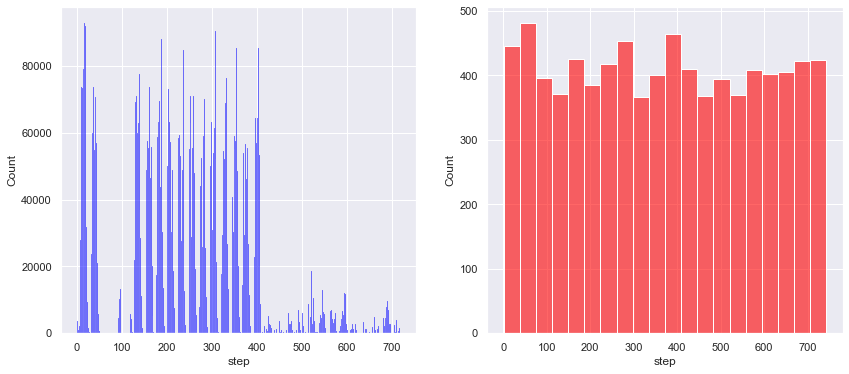

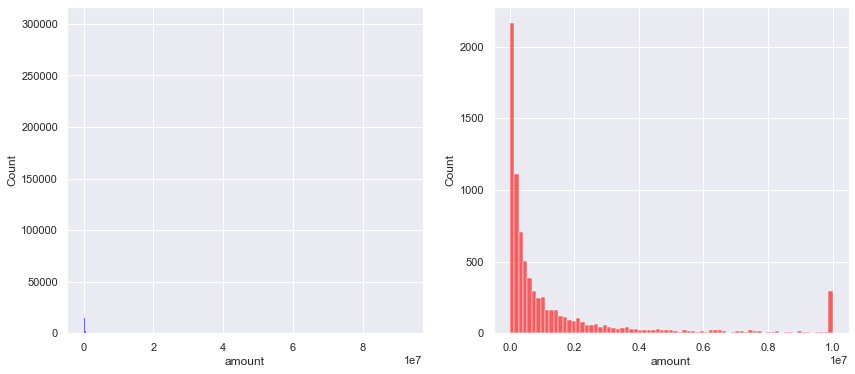

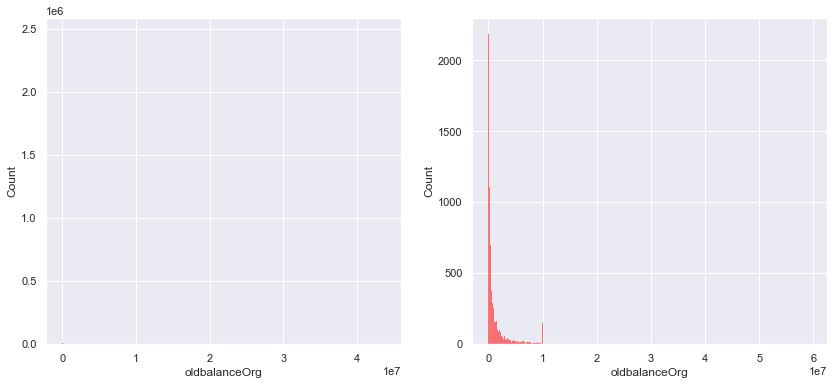

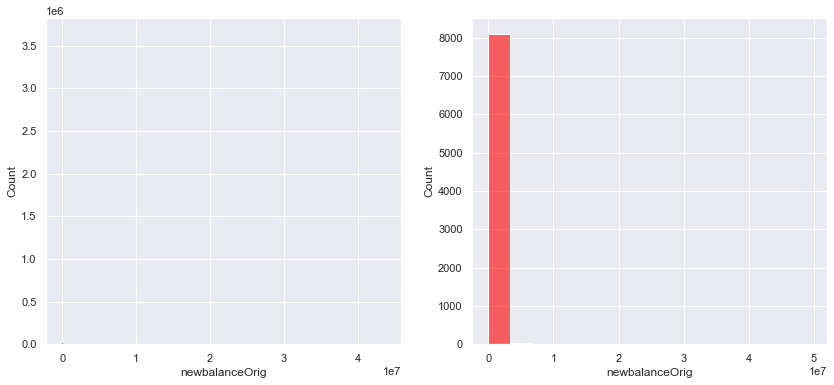

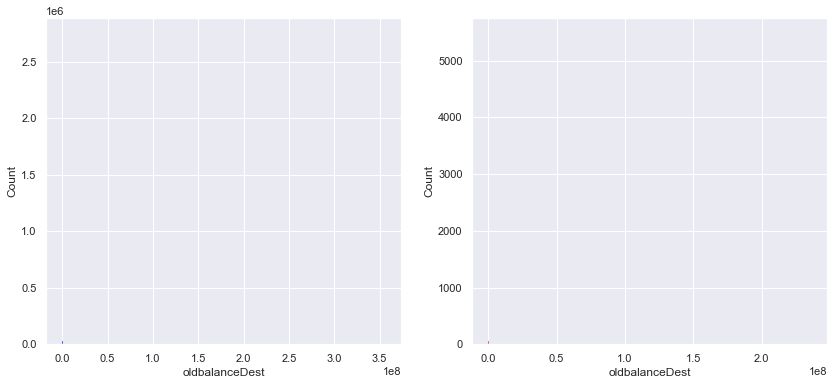

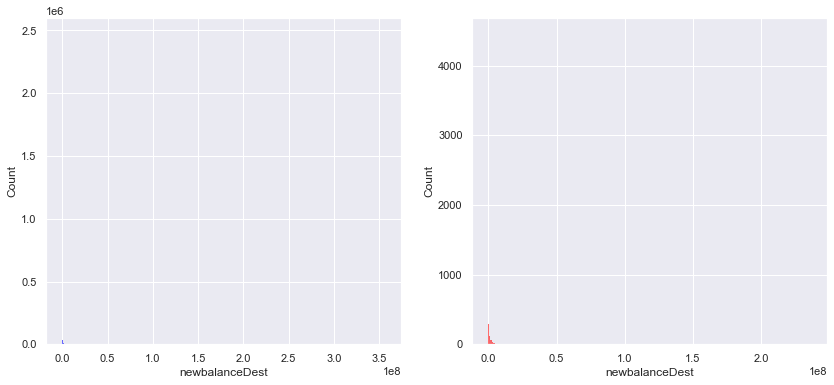

In [9]:
for i in num_cols:
    fig,ax = plt.subplots(1,2,figsize=(14,6))
    sns.histplot(data=df.loc[df['isFraud']==0],x=i,alpha=0.6,color='blue',ax=ax[0])
    sns.histplot(data=df.loc[df['isFraud']==1],x=i,alpha=0.6,color='red',ax=ax[1])
    plt.show()

Very skewed numerical data. Step seems to be an important variable. <br>
type (of payment) is an important categorical variable (the only one), which separates the classes as fraudulent class takes only values transfer and cash_out for this feature, and none others.

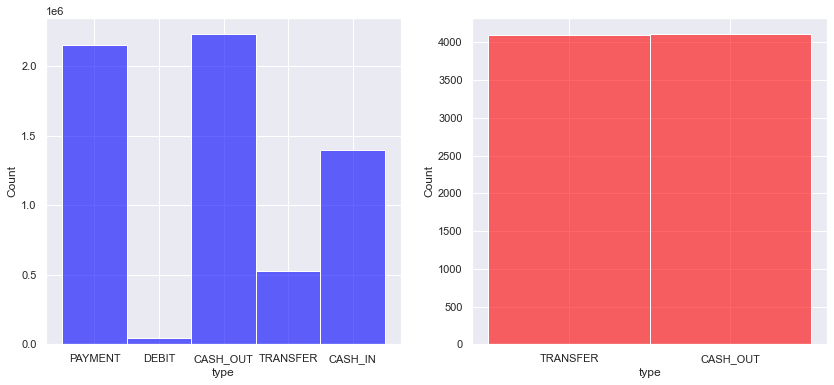

In [10]:
for i in cat_cols:
    fig,ax = plt.subplots(1,2,figsize=(14,6))
    sns.histplot(data=df.loc[df['isFraud']==0],x=i,alpha=0.6,color='blue',ax=ax[0])
    sns.histplot(data=df.loc[df['isFraud']==1],x=i,alpha=0.6,color='red',ax=ax[1])
    plt.show()

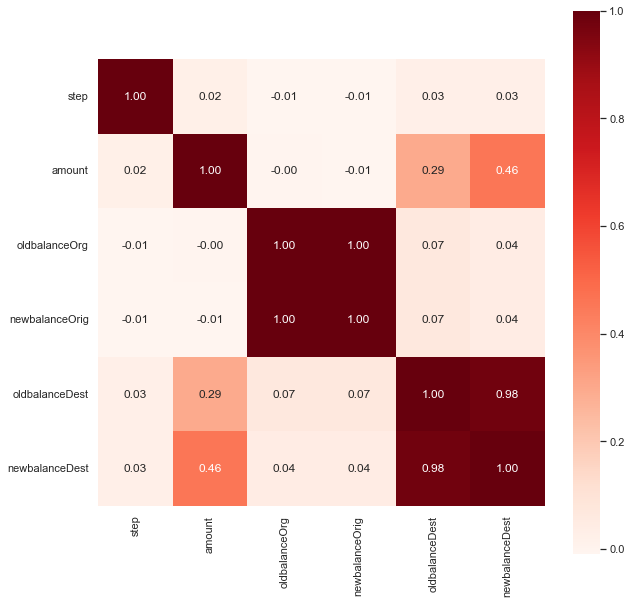

In [11]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(df[num_cols].corr(),square=True,annot=True,cbar=True,cmap='Reds',fmt=".2f",ax=ax)
plt.show()

oldbalanceOrg and newbalanceOrig are 100% correlated - so drop newbalanceOrig. <br>
oldbalanceDest and newbalanceDest are 98% correlated - so drop newbalanceDest. <br>

In [24]:
df.drop(['oldbalanceDest','newbalanceDest'],axis=1,inplace=True)

In [9]:
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0
2,1,TRANSFER,181.00,181.00,0.00,1
3,1,CASH_OUT,181.00,181.00,0.00,1
4,1,PAYMENT,11668.14,41554.00,29885.86,0
...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,1
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,1
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,1
6362618,743,TRANSFER,850002.52,850002.52,0.00,1


### Resampling

I will under-sample the majority class to match the number of minority class samples

In [25]:
n0, n1 = df['isFraud'].value_counts() #number of instances in each class

class0 = df[df['isFraud']==0]
class1 = df[df['isFraud']==1]

In [26]:
print("Before Resampling")
print("Percentage of Class 0: {:.2f}%".format(n0/(n0+n1)*100)) 
print("Percentage of Class 1: {:.2f}%".format(n1/(n0+n1)*100))

class0under = class0.sample(n1,replace=False)
underdf = pd.concat([class0under,class1],axis=0).sample(frac=1)

print("After Resampling")
print("Fraction of Class 0: {:.2f}%".format(underdf['isFraud'].value_counts()[0]/underdf.shape[0]*100))
print("Fraction of Class 1: {:.2f}%".format(underdf['isFraud'].value_counts()[1]/underdf.shape[0]*100))

Before Resampling
Percentage of Class 0: 99.87%
Percentage of Class 1: 0.13%
After Resampling
Fraction of Class 0: 50.00%
Fraction of Class 1: 50.00%


### Model Fitting

In [27]:
X_train, X_test, y_train, y_test = train_test_split(underdf.drop(['isFraud'],axis=1),underdf['isFraud'],
                                                    test_size=0.2,random_state=2)

I will train only the CatBoostClassifier - that's how much confidence I have in CatBoost.

In [28]:
cat = CatBoostClassifier(verbose=False)
cat.fit(X_train, y_train,cat_features=['type'])

In [29]:
y_pred_test = cat.predict(X_test)
y_pred_train = cat.predict(X_train)

y_pred_proba_test = cat.predict_proba(X_test)[:,1].reshape(-1,1)
y_pred_proba_train = cat.predict_proba(X_train)[:,1].reshape(-1,1)

#prediction on Whole dataset - so it includes the instances of negative class which were dropped
y_pred = cat.predict(df.drop(['isFraud'],axis=1))
y_pred_proba = cat.predict_proba(df.drop(['isFraud'],axis=1))[:,1].reshape(-1,1)

In [15]:
print("Classification Reports")
print("Test Set")
print(classification_report(y_test,y_pred_test))

print("Train Set")
print(classification_report(y_train,y_pred_train))

print("Whole  dataset")
print(classification_report(df['isFraud'],y_pred))

Classification Reports
Test Set
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1619
           1       0.99      1.00      0.99      1667

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Train Set
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6594
           1       0.99      1.00      1.00      6546

    accuracy                           1.00     13140
   macro avg       1.00      1.00      1.00     13140
weighted avg       1.00      1.00      1.00     13140

Whole  dataset
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   6354407
           1       0.10      1.00      0.19      8213

    accuracy                           0.99   6362620
   macro avg       0.55      0.99      0.59   6362620
weighted avg     

In [16]:
print("ROC-AUC Scores")
print("\nTest Set")
print(roc_auc_score(y_test,y_pred_proba_test))

print("\nTrain Set")
print(roc_auc_score(y_train,y_pred_proba_train))

print("\nWhole  dataset")
print(roc_auc_score(df['isFraud'],y_pred_proba))

ROC-AUC Scores

Test Set
0.9990484917222856

Train Set
0.999929884225686

Whole  dataset
0.9995441647688433


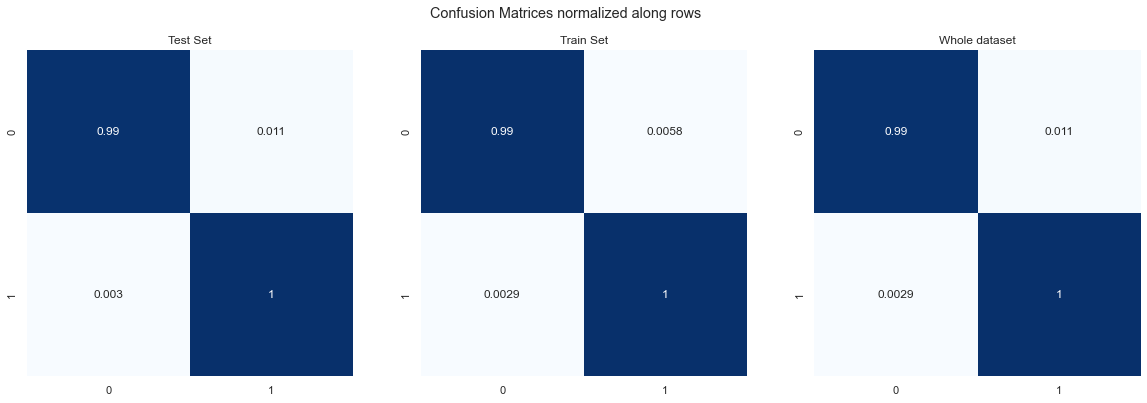

In [17]:
fig,ax = plt.subplots(1,3,figsize=(20,6))
plt.suptitle("Confusion Matrices normalized along rows")
sns.heatmap(confusion_matrix(y_test,y_pred_test,normalize='true'),annot=True,cbar=False,square=True,cmap='Blues',ax=ax[0])
ax[0].set_title("Test Set")

sns.heatmap(confusion_matrix(y_train,y_pred_train,normalize='true'),annot=True,cbar=False,square=True,cmap='Blues',ax=ax[1])
ax[1].set_title("Train Set")

sns.heatmap(confusion_matrix(df['isFraud'],y_pred,normalize='true'),annot=True,cbar=False,square=True,cmap='Blues',ax=ax[2])
ax[2].set_title("Whole dataset")
plt.show()

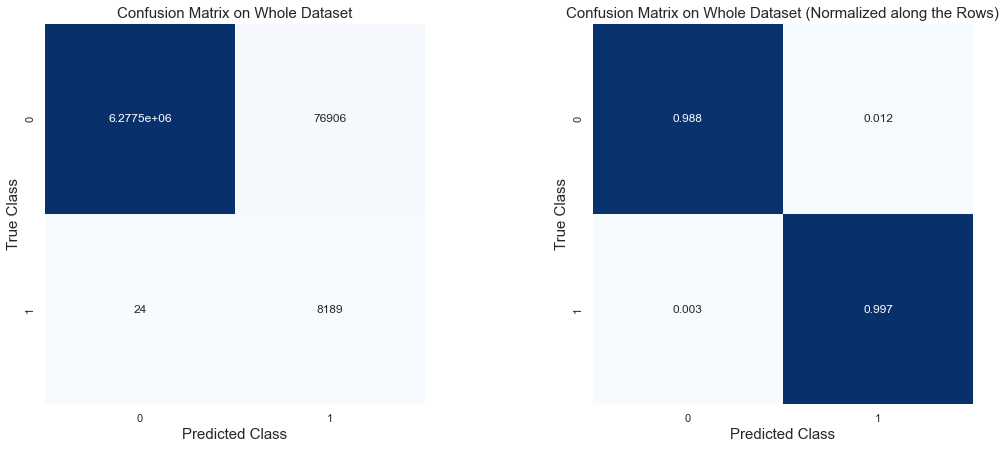

In [31]:
fig,ax = plt.subplots(1,2,figsize=(18,7))
sns.heatmap(confusion_matrix(df['isFraud'],y_pred),annot=True,cbar=False,square=True,cmap='Blues',fmt='g',ax=ax[0])
ax[0].set_title("Confusion Matrix on Whole Dataset",fontsize=15)
ax[0].set_xlabel("Predicted Class",fontsize=15)
ax[0].set_ylabel("True Class",fontsize=15)

sns.heatmap(confusion_matrix(df['isFraud'],y_pred,normalize='true'),annot=True,cbar=False,square=True,cmap='Blues',fmt='.3f',ax=ax[1])
ax[1].set_title("Confusion Matrix on Whole Dataset (Normalized along the Rows)",fontsize=15)
ax[1].set_xlabel("Predicted Class",fontsize=15)
ax[1].set_ylabel("True Class",fontsize=15)
plt.show()

So, with respect to not missing the instances of fraud, the model is performing very well. <br>

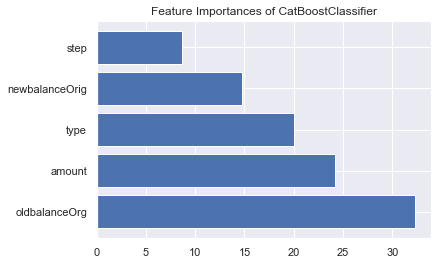

In [18]:
feat_imp_sorted_str = np.flip(np.sort(cat.feature_importances_))
feat_imp_sorted_args_str = np.flip(np.argsort(cat.feature_importances_))
feat_names_sorted_str = X_train.columns[feat_imp_sorted_args_str]

plt.barh(feat_names_sorted_str,feat_imp_sorted_str)
plt.title("Feature Importances of CatBoostClassifier")
plt.show()

In [19]:
pickle.dump(cat,open('catboost_online_fraud_detection.pkl','wb'))